Continuing previous [post](../post-06-tensorflow-regression-basics), this demo will show you how to leverage TensorFlow 2 (TF2) for dealing with classification problems. An additional technique to tune hyperparameter (which in this case is the number of epochs) is presented here. Similar to the previous demo, the data for illustration is randomly generated using `numpy` library.

The objective of this demo is to show you the main elements of working with a TF2 model to tackle classification problems. 

## Setup

The setup includes importing important libraries (`tensorflow`, `numpy`, and `matplotlib.pyplot`), freeing memory from old models/layers (if any) and setting the seed for random number generator. 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(123)

## Generate Random Data

For this use case, I genereated two classes of data based on multivariate normal distribution with specified means and covariance matrices. Both values are determined arbitrarily.

In [3]:
# random data generation
SAMPLE_SIZE = 1500

class_1 = np.random.multivariate_normal(
    mean = [0, 2],
    cov  = [[1, 0.1], [0.1, 1]],
    size = SAMPLE_SIZE
)

class_2 = np.random.multivariate_normal(
    mean = [2, 0],
    cov  = [[1, 0.1], [0.1, 1]],
    size = SAMPLE_SIZE
)

# append both classes
X = np.concatenate([class_1, class_2])
X = X.astype("float32")

y = np.concatenate([np.zeros((SAMPLE_SIZE, 1)), np.ones((SAMPLE_SIZE, 1))])
y = y.astype("int")

X.shape, y.shape

((3000, 2), (3000, 1))

As there are only two variables within the data, making sense of it is easier as we only requires a scatter plot to see how data is dispersed along x and y axes. As you can see from the figure below, there is an area where points from class 1 and class 2 overlap.

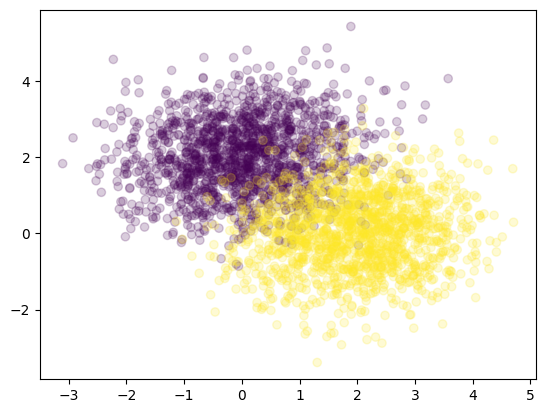

In [4]:
#| fig-align: center

plt.scatter(X[:, 0], X[:, 1], c = y[:, 0], alpha = .2)
plt.show()

## Slice the Data

To help slicing two python variables with the same length (`X` and `y`), I created a vector of data indices where the order is shuffled. This then server as a reference to determine which points belong to which datasets (training, validation, or testing).

I split the data into train and test datasets (80% and 20%), before splitting the train dataset further for hyperparameter tuning into partial train and validation (80% and 20%). 

In [5]:
# define randomized indices for splitting
indices = np.arange(SAMPLE_SIZE * 2)
np.random.shuffle(indices)

# split data into `train` and `test datasets`
split_locaction = round(SAMPLE_SIZE * .8)

X_train = X[indices[:split_locaction]]
y_train = y[indices[:split_locaction]]

X_test = X[indices[split_locaction:]]
y_test = y[indices[split_locaction:]]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1200, 2), (1200, 1), (1800, 2), (1800, 1))

In [6]:
# split train data into `partial` and `validation` for hyperparameter tuning
split_locaction = round(len(X_train) * .8)

partial_X_train = X_train[:split_locaction]
partial_y_train = y_train[:split_locaction]

X_val = X_train[split_locaction:]
y_val = y_train[split_locaction:]

partial_X_train.shape, partial_y_train.shape, X_val.shape, y_val.shape

((960, 2), (960, 1), (240, 2), (240, 1))

## Hyperparameter Optimization

Hyperparameter optimization or tuning can be applied to any parameters controlling the behaviours of the machine learning algorithm which are not learned during training. In doing so, we need to separate the test data and leverage two subsets of training data instead. Otherwise, there might be any leak of information from the 'unseen data' which might alter the result of the trained algorithm giving it the capability to perform better on the test dataset. This opposes the idea of ML model that should be able to do well given unknown input, which, in this case is represented as test dataset.

The hyperparameter to be tuned is the simple one, in this case number of epochs.The process includes training a network with simplifed architecture, then analyses the performance of the network throughout the training. The optimal number of epochs is decided based on how accuracy and loss values moves throughout time.

The actual workflow for creating the model, compiling its optimizer, loss function, and metrics, and fitting it to the data is similar to what you can see from the previous demo. The difference here is that I did not use `model.add` method to put a layer in the model. Instead, I gave a list of several `Dense` layers as an argument when instantiating a `Sequential` model. In addition, the number of units in each layer is a reduced one (we will increase it when training with full train data). I also set the learning rate for the `SGD` optimizer into 0.005.

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(8, input_shape = (2,), activation = "relu"),
    tf.keras.layers.Dense(8, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.005), 
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

history = model.fit(partial_X_train, 
                    partial_y_train, 
                    validation_data=(X_val, y_val), 
                    epochs = 1000, 
                    verbose = 0)

The model is fitted using the `partial_X_train` and `partial_y_train` with a set of validation data. By using validation data, we might observe how the performance of the model throughout training.

Below, we can see the values of training and validation accuracy and loss given a certain training epoch. Because of the values for the validation seems to resemble training values, it can be inferred that the model does not overfit. Overfitting may cause the training accuracy to be significantly higher than validation accuracy and training loss to be significantly lower than validation loss.

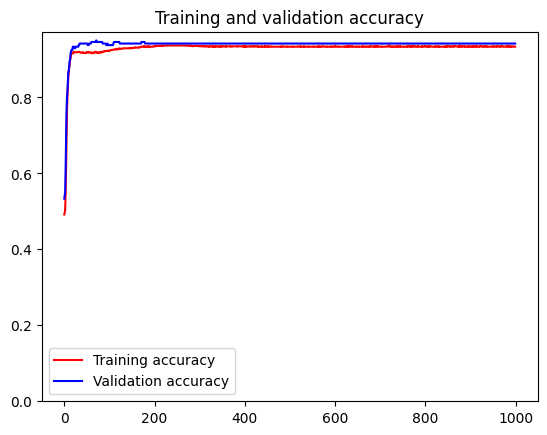

In [8]:
#| fig-align: center

# Plot the training results
accuracy     = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs       = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylim(ymin=0)
plt.legend()
plt.show()

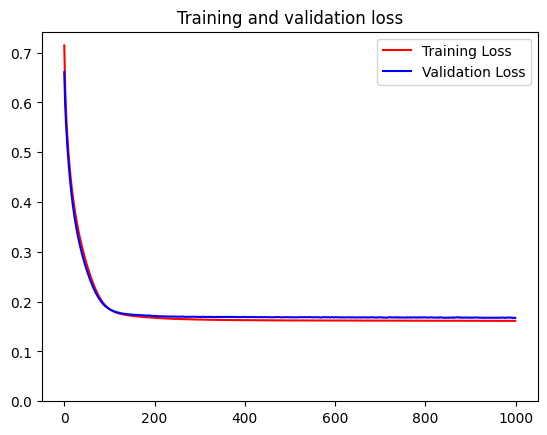

In [9]:
#| fig-align: center

# Plot the training results
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(len(accuracy))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.ylim(ymin=0)
plt.legend()
plt.show()

## Fitting with Full Training Data

After observing how the simplified model performs, we were able to decide at which epoch we want to stop training our model. In this case, we selected 175 as the subsequent epochs does not give improvement to the model (the loss seemed to stop decreasing). We then could fit our model with full training data and increase the number of units for each `Dense` layer.

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, input_shape = (2,), activation = "relu"),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.005), 
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

history = model.fit(X_train, y_train, epochs = 175, verbose = 0)

Next, we see how the model classifies each data point from the graph below.

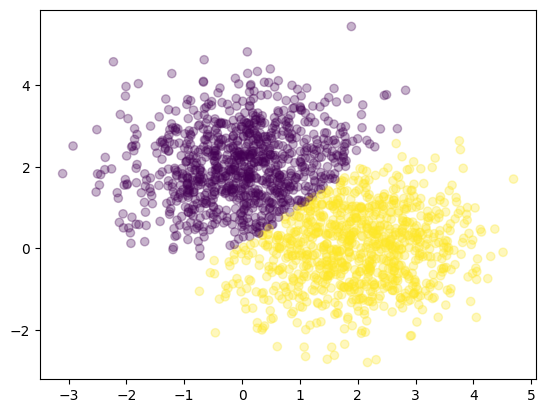

In [11]:
#| fig-align: center

y_pred = model.predict(X_test, verbose = 0)

plt.scatter(X_test[:, 0], X_test[:, 1], c = y_pred[:, 0] > .5, alpha = .3)
plt.show()

We could also `evaluate` the performance on the test dataset. The model can reach more than 80% accuracy.

In [12]:
loss, accuracy = model.evaluate(X_test, y_test, verbose = 0)

print(f"Loss    : {loss:.3f}")
print(f"Accuracy: {accuracy:.3f}")

Loss    : 0.176
Accuracy: 0.926


## Conclusion

In this post, we continue our demonstration of TensorFlow 2 with classification problems. The model successfully achieve a decent accuracy score for this simple case. Additionally, we have touched the concept of hyperparameter tuning which is essential for doing machine learning.